In [58]:
import torch
import torch.nn as nn
import spacy
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import re

from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
!python -m spacy download en_core_web_lg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 16 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [3]:
nlp = spacy.load("en_core_web_lg")

In [4]:
class Vocabulary:
  def __init__(self, freq_theshold=1):
    self.itos = {
        0: '<SOS>',
        1: '<EOS>',
        2: '<UNK>',
        3: '<PAD>'
    }

    self.stoi = {
        '<SOS>': 0, 
        '<EOS>': 1,
        '<UNK>': 2,
        '<PAD>': 3
    }

    self.threshold = freq_theshold

  def __len__(self):
    return len(self.stoi)

  def tokenizer(self, sentence):
    return [str(token).lower() for token in nlp.tokenizer(sentence)]
  
  def create_vocab(self, text):
    freq = {}
    idx = 4
    for sentence in text:
      for word in self.tokenizer(sentence):
        if word not in freq:
          freq[word] = 1
        else:
          freq[word] += 1
        
        if freq[word] == self.threshold:
          self.stoi[word] = idx
          self.itos[idx] = word
          idx += 1

  def encode(self, sentence):
    tokenized = self.tokenizer(sentence)
    return [
          self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized
      ]

  def decode(self, indices):
    return " ".join([self.itos[idx.item()] for idx in indices])


In [15]:
class Cleaning:
  def preprocess(self):
    self.data = pd.read_csv(file, sep="\t")
    target = self.data.pop('Liked').values
    li = []
    for i in range(self.data.shape[0]):
      string = self.data['Review'][i]
      string = re.sub(r'[-?$%^&*@#+/.\'\"]+', ' ', string)
      string = re.sub(r'\s{2,}', ' ', string)
      token = nlp(string)
      li.append(" ".join([str(word.lemma_) for word in token if not word.is_punct]).strip())
    self.data['Review'] = li
    return self.data.values.squeeze(), target

In [6]:
class ReviewSet(Dataset):
  def __init__(self, file):
    super(Dataset, self).__init__()
    (self.features, self.target) = Cleaning().preprocess(file)
    self.vocab = Vocabulary()
    self.vocab.create_vocab(self.features)

  def __len__(self):
    return len(self.features)
  
  def __getitem__(self, index):
    text = self.features[index]
    encoded = [self.vocab.stoi['<SOS>']]
    encoded += self.vocab.encode(text)
    encoded.append(self.vocab.stoi['<EOS>'])

    target = self.target[index]
    return torch.tensor(encoded), torch.FloatTensor([target])


In [7]:
dataset = ReviewSet("data.tsv")

- `pad_sequence`: use to pad the sequence in a batch with provided padding value.
- `pack_padded_sequence`: use to pack the above padded or prev padded sequence to optimize the calculations inside RNN or lstm

> Note: If packed input is passed in LSTM then output will also be packed

- `pad_packed_sequence`: To unpack the packed padded sequence, normally after recieving the packed output from LSMT we unpack it to process it further.

In [8]:
# Collate function, it recieves the list as input
# Input: [(x1, y1), (x2,y2).....]
class BatchPad:
  def __init__(self, pad_idx):
    self.pad_idx = pad_idx

  def __call__(self, batch):
    features = [item[0] for item in batch]
    lengths = torch.tensor([item.shape[0] for item in features])
    features = pad_sequence(features, batch_first=False,
                               padding_value=self.pad_idx)
    target = torch.tensor([item[1] for item in batch])

    return (features, lengths), target

> Remember: `hidden` and `cell` are the matrix output for the `h0` and `c0` matrix you passed along with input. For completely different data samples you don't need to pass the same `hidden` and `cell` as of prev sample. Ultimately these are not the trainable parameters. `LSTM`'s inner `Wh` and `Wc` are the trainiable paramters and those been kept and used over and over again as you call the network.

> You need to pass them when you are working on the sample sample like generating some text. For completely different sample from dataloader passing a 0 vector for both `h0` and `c0` is the right choice.

In [42]:
class Classifier(nn.Module):
  def __init__(self, vocab_size, hidden_size, num_layers, embed_size, bidirectional=False):
    super(Classifier, self).__init__()
    
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.vocab_size = vocab_size

    # layers
    self.embed = nn.Embedding(vocab_size, embed_size)
    self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, bidirectional=bidirectional)
    if bidirectional:
      self.linear = nn.Linear(2*hidden_size, 1)
    else:
      self.linear = nn.Linear(hidden_size, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, features, text_lengths):
    embeddings = self.embed(features) # (num_words, batch, 300)

    # pack the padded sequence
    packed_embeds = pack_padded_sequence(embeddings, text_lengths.to('cpu'), enforce_sorted=False)
    # LSTM returns the packed output for packed input
    packed_output, _ = self.lstm(packed_embeds)
    # unpack the ouput for further use
    unpacked_output, _ = pad_packed_sequence(packed_output)

    logits = self.linear(unpacked_output)
    logits = logits.permute(1,0,2)
    preds = self.sigmoid(logits[:,-1,:])
    return preds

  def init_hidden(self, batch_size, device):
    if bidirectional:
      hidden = torch.zeros(2*self.num_layers, batch_size, self.hidden_size).to(device)
      cell = torch.zeros(2*self.num_layers, batch_size, self.hidden_size).to(device)
    else:
      hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
      cell = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
    return hidden, cell

In [110]:
vocab_size = len(dataset.vocab)
hidden_size = 256
num_layers = 2
embed_size = 300
batch_size = 32
epochs = 2000
lr = 0.0003
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [111]:
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=BatchPad(dataset.vocab.stoi['<PAD>']), drop_last=False)

In [112]:
model = Classifier(vocab_size, hidden_size, num_layers, embed_size, True).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criteria = nn.BCELoss()

In [113]:
losses = []
loop = tqdm(range(1, epochs+1), total=epochs)
for epoch in loop:
  epoch_loss = 0
  for (features, text_length), target in loader:
    optimizer.zero_grad()
    features = features.to(device)
    target = target.to(device)
    preds = model(features, text_length)
    loss = criteria(preds.squeeze(), target)
    epoch_loss += loss.item()
    loss.backward()
    optimizer.step()
  losses.append(epoch_loss)

100%|██████████| 2000/2000 [13:04<00:00,  2.55it/s]


In [114]:
def testing_preprocess(sentence, vocab, device):
  cleaned_text = Cleaning().test_preprocess(sentence)
  encoded = [vocab.stoi['<SOS>']]
  encoded += vocab.encode(cleaned_text)
  encoded.append(vocab.stoi['<EOS>'])
  return torch.tensor(encoded).to(device)

In [115]:
sentence = 'very poor food'
test_case = testing_preprocess(sentence, dataset.vocab, device)
model(test_case.unsqueeze(1), torch.tensor(test_case.shape[0]).unsqueeze(0))

tensor([[0.0341]], device='cuda:0', grad_fn=<SigmoidBackward0>)

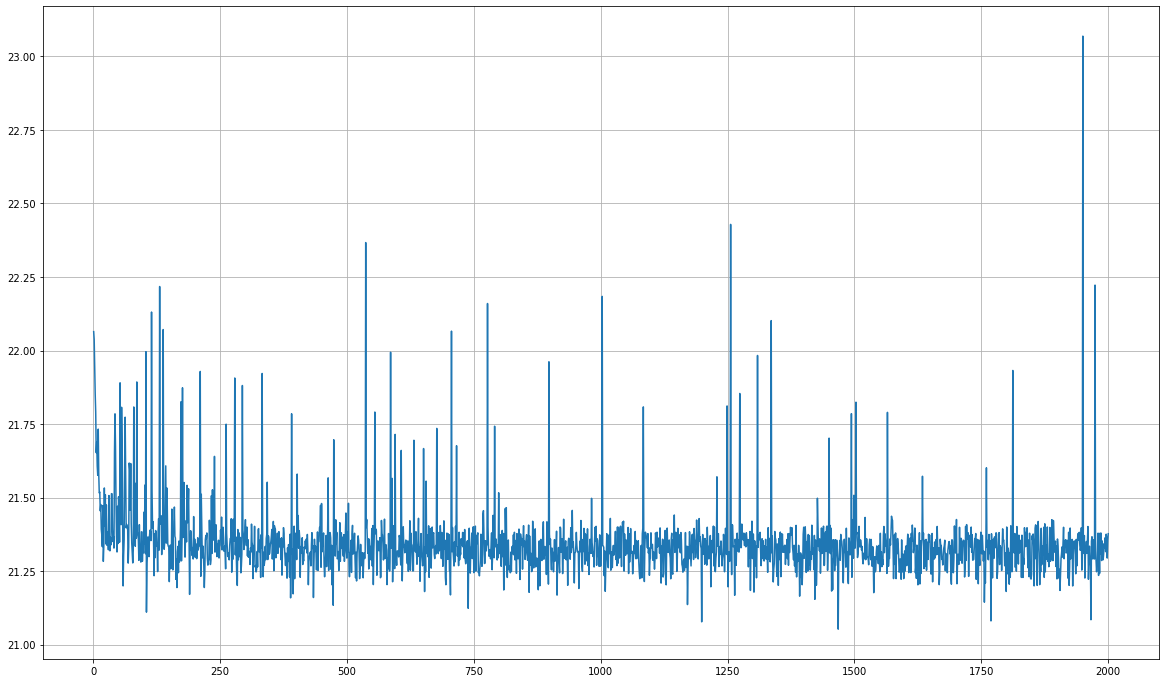

In [116]:
plt.figure(figsize=(20,12))
plt.grid(True)
plt.plot(list(range(1,epochs+1)), losses)

In [117]:
t_loader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=BatchPad(dataset.vocab.stoi['<PAD>']), drop_last=False)
predictions = []
targets = []
with torch.inference_mode():
  for (features, text_length), target in t_loader:
      features = features.to(device)
      targets.append(target.item())
      preds = model(features, text_length)
      predictions.append(1 if preds.view(-1).item() > 0.5 else 0)

In [118]:
(torch.sum(torch.tensor(targets) == torch.tensor(predictions))/1000).item()*100

83.09999704360962